# Week 4 - Problem Definition
___

## Business Understanding

How to choose the restaurant in the New York metropolitan area?

To choose where to eat in New York, one could employ several approaches, for example, to pick:
- The best cost per benefit;
- The most popular in the region;
- The best fit for its requirements.

## Approach and Requirement

Descriptive Analytics:
- **Popularity**, number of `likes`;
- **Cost per benefit**, ratio of `price` over `rating`;
- **Concentration**, distribution of `location`.

Predictive Approach:
- Prescribe **neighbourhood** given requirements.

### Methodology

For this project it's needed an holistic approach where both descriptive and predictive analytics are employed.
A descriptive analysis will generate cost per benefit and popularity for each area. While, a predictive model will result in the best place given requirements.

The predictive model choosen is a decision tree with rating, likes and price (requirements) as features and neighbourhood as target.

### Data Sources

The data will be obtained from an Airbnb data source and from Foursquare and Geolocator API.\
Airbnb data source: http://insideairbnb.com/get-the-data.html.

# Week 5 - New York Restaurants 
___

## Data Collection

### Import Libraries

Built-in Python

In [2]:
import json, pathlib

Data Analysis

In [3]:
import numpy as np
import pandas as pd

Data Visualization

In [4]:
import matplotlib.pyplot as plt

Machine Learning

In [5]:
from sklearn import preprocessing, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from joblib import dump, load

Other Libraries

In [6]:
import requests, folium

from geopy.geocoders import Nominatim

### Airbnb Data - Neighbourhood and Area Names

In [7]:
geojson = r'./neighbourhoods.geojson'

In [8]:
df_ny = pd.read_csv('./neighbourhoods.csv', index_col='neighbourhood')

In [9]:
df_ny.index.name = 'neighbourhood'

In [10]:
df_ny.head()

,neighbourhood_group
neighbourhood,
Allerton,Bronx
Baychester,Bronx
Belmont,Bronx
Bronxdale,Bronx
Castle Hill,Bronx


In [11]:
df_ny[['latitude', 'longitude']] = np.nan

In [12]:
df_areas = pd.DataFrame(columns=['latitude','longitude'],index=df_ny['neighbourhood_group'].unique())

In [13]:
df_areas.index.name = 'neighbourhood_group'

In [14]:
df_areas.head()

,latitude,longitude
neighbourhood_group,,
Bronx,NaN,NaN
Brooklyn,NaN,NaN
Manhattan,NaN,NaN
Queens,NaN,NaN
Staten Island,NaN,NaN


## Geolocator API - Neighbourhood and Area Location

In [15]:
address = ', New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")

def locate(df):

    for idx in df.index:
        loc = geolocator.geocode(idx + address)
        
        if loc is None:
            continue

        df.loc[[idx],['latitude']] = loc.latitude
        df.loc[[idx],['longitude']] = loc.longitude

In [16]:
locate(df_ny)
locate(df_areas)

In [17]:
df_ny.dropna(inplace=True)

In [18]:
df_areas.dropna(inplace=True)

### Foursquare API - Search Venue

In [19]:
CLIENT_ID = 'PNC41IKLXMVLKVCZ5CSL3044KIAEY1ACPRIIEXODK3DEYMX1'
CLIENT_SECRET = 'EELGU3BTHACFHWF13KM42Y2LZO4DUFR2451JFXOVWLR3M5Y4'
VERSION = '20180605'
LIMIT = 100

Request search venues for each neighbourhood:

In [20]:
url = f'https://api.foursquare.com/v2/venues/search'
search_data = list()
for neighbourhood in df_ny.index:
    params = dict(
        client_id = CLIENT_ID,
        client_secret = CLIENT_SECRET,
        v = VERSION,
        near = neighbourhood,
        query = 'Restaurant',
        limit = 100,
        radius = 500
    )
    response = requests.get(url = url, params = params)
    search_data.append(json.loads(response.text))

Function to check and return field in the json data:

In [21]:
check = lambda name, table: table[name] if name in table.keys() else np.nan;

Extract general information about each venue from response data:

In [45]:
df_venues = pd.DataFrame()

for i in range(len(search_data)):
    venues = check('venues', search_data[i]['response']);
    
    if venues is np.nan:
        continue;
        
    for venue in venues:
        df_venues = df_venues.append({
            'neighbourhood':\
                df_ny.index[i],
            'neighbourhood_group':\
                df_ny.at[df_ny.index[i],'neighbourhood_group'],
            'id':\
                venue['id'],
            'names':\
                venue['name'],
            'category':\
                venue['categories'][0]['name'] if len(venue['categories']) else np.nan,
            'latitude':\
                venue['location']['lat'],
            'longitude':\
                venue['location']['lng'],
        }, ignore_index = True)
        
df_venues = df_venues.set_index('id')

## Data Sampling

Filter in restaurant venues type:

In [46]:
df_venues = df_venues[df_venues['category'].str.contains('Restaurant', na=False)]

Drop irrelevant venues:

In [47]:
irrelevant = ['Restaurant','Food', 'Sushi Restaurant','Seafood Restaurant', 'Vegetarian / Vegan Restaurant', 'New American Restaurant']

In [48]:
df_venues = df_venues[~df_venues['category'].isin(irrelevant)]

Select relevant restaurants:

In [49]:
relevant = list(df_venues['category'].value_counts().head(15).index)

In [50]:
df_venues = df_venues[df_venues['category'].isin(relevant)]

Sample the data (limited calls):

In [51]:
df_venues = df_venues.sample(n = 250, random_state=1)

## Additional Data Collection

### Foursquare API - Venue's Information

Request information for each restaurant:

In [52]:
restaurant_data = list()

for venue_id in df_venues.index:
    url = f'https://api.foursquare.com/v2/venues/{venue_id}'
    params = dict(client_id = CLIENT_ID,
                  client_secret = CLIENT_SECRET,
                  v = VERSION)
    response = requests.get(url = url, params = params)
    restaurant_data.append(json.loads(response.text))

Extract specific information about each venue from response data:

In [53]:
for idx in range(len(restaurant_data)):
    venue = check('venue', restaurant_data[idx]['response']);
    
    if venue is np.nan:
        continue;
        
    price = check('price', venue);
    tier = check('tier', price);
    df_venues.loc[[venue['id']], ['price']] = tier;
    rating = check('rating', venue);
    df_venues.loc[[venue['id']], ['rating']] = rating;
    likes = check('likes', venue);
    count = check('count', likes);
    df_venues.loc[[venue['id']], ['likes']] = count;

##

## Data Prepocessing - Descriptive Analysis

Fill fields for each dataframe (consistency):

In [54]:
df_venues['ratio'] = df_venues['price'] / df_venues['rating'] * 2.5

In [55]:
df_ny = df_ny.merge(df_venues.loc[~df_venues['rating'].isnull()].groupby('neighbourhood')['rating'].mean(), on='neighbourhood')
df_ny = df_ny.merge(df_venues.loc[~df_venues['price'].isnull()].groupby('neighbourhood')['price'].mean(), on='neighbourhood')
df_ny = df_ny.merge(df_venues.groupby('neighbourhood')['likes'].sum(), on='neighbourhood')

In [56]:
df_ny['ratio'] = df_ny['price'] / df_ny['rating'] * 2.5

In [57]:
df_areas = df_areas.merge(df_venues.loc[~df_venues['rating'].isnull()].groupby('neighbourhood_group')['rating'].mean(), on='neighbourhood_group')
df_areas = df_areas.merge(df_venues.loc[~df_venues['price'].isnull()].groupby('neighbourhood_group')['price'].mean(), on='neighbourhood_group')
df_areas = df_areas.merge(df_venues.groupby('neighbourhood_group')['likes'].sum(), on='neighbourhood_group')

In [58]:
df_areas['ratio'] = df_areas['price'] / df_areas['rating'] * 2.5

## Data Exploration

### Categorical Analysis

**Distribution of Restaurants**

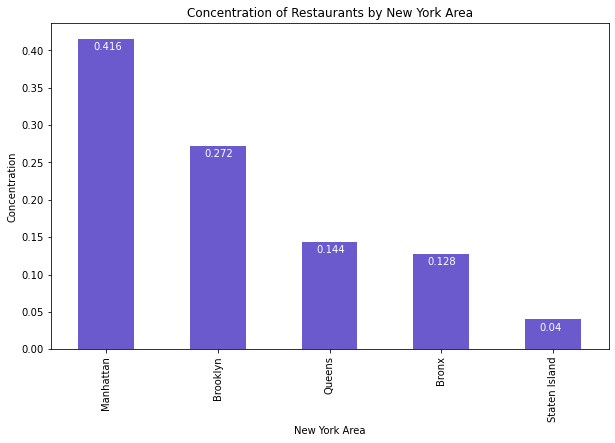

In [59]:
series = df_venues['neighbourhood_group'].value_counts(normalize = True).sort_values(ascending = False)
series.plot(kind='bar', figsize = (10, 6), color = 'slateblue')

labels = []

for index, value in enumerate(series.values):
    plt.annotate(value,xy=(index - 0.12, value - 0.015) , color = 'white')

plt.title('Concentration of Restaurants by New York Area')
plt.xlabel('New York Area')
plt.ylabel('Concentration')

plt.show()

**Distribution of Cuisines**

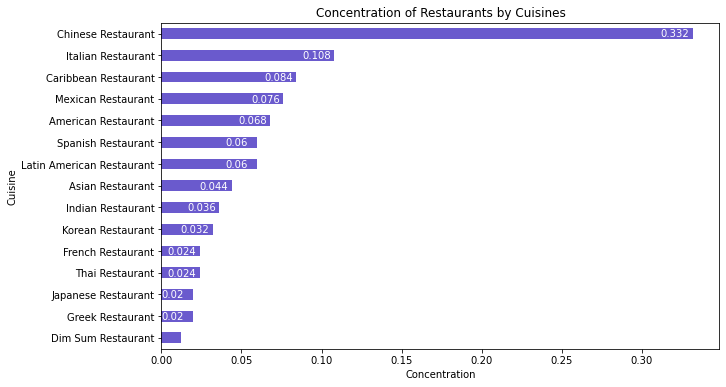

In [60]:
series = df_venues['category'].value_counts(normalize = True).sort_values(ascending = True)
series.plot(kind='barh', figsize = (10, 6), color = 'slateblue')
labels = []

for index, value in enumerate(series.values):
    plt.annotate(value,xy=(value - 0.02, index - 0.15) , color = 'white')
    
plt.title('Concentration of Restaurants by Cuisines')
plt.xlabel('Concentration')
plt.ylabel('Cuisine')

plt.show()

### Quantitative Analysis

**Descriptive Stats by Area**

In [61]:
df_areas.sort_values('likes', ascending = False)

,latitude,longitude,rating,price,likes,ratio
neighbourhood_group,,,,,,
Manhattan,40.7896,-73.9599,7.327273,1.777778,1360.0,0.606562
Brooklyn,40.6501,-73.9496,6.750000,1.727273,97.0,0.639731
Bronx,40.8467,-73.8786,8.250000,1.583333,47.0,0.479798
Queens,40.7498,-73.7976,6.700000,1.714286,30.0,0.639659


**Note: ratio is cost (price) per benefit (rating) and likes is popularity**

### Data Prepocessing - Predictive Model

In [62]:
df_venues = df_venues.reset_index()

Fill NaN cells with the mean of the columns:

In [63]:
def nan_to_mean(series):
    series.replace(np.nan, series.astype("float").mean(axis=0), inplace=True)

nan_to_mean(df_venues['price'])
nan_to_mean(df_venues['rating'])
nan_to_mean(df_venues['likes'])
nan_to_mean(df_venues['ratio'])

Define `df_feature` and `target` dataframes:

In [64]:
df_feature = df_venues[['price', 'rating', 'likes']]
df_target = df_venues[['neighbourhood']]

Perform one hot encoding in `df_target`:

In [65]:
df_target = pd.concat([pd.get_dummies(df_target['neighbourhood'])], axis=1)

Split between train and test datasets:

In [66]:
df_feature = preprocessing.StandardScaler().fit(df_feature).transform(df_feature)

In [67]:
X_train, X_test, y_train, y_test = map(np.array,train_test_split(df_feature, df_target, train_size=0.9))

## Data Modelling

Build `tree` model given best `k`: 

In [68]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

Train `tree` model with the train dataset (`x_train` and `y_train`):

In [69]:
model = tree.fit(X_train, y_train)

## Model Evaluation

Check R² score for with the test dataset (`X_test` and `y_test`):

In [70]:
yhat = tree.predict(X_test)
print('Decision Tree Model Accuracy:',metrics.r2_score(y_test, yhat))

Decision Tree Model Accuracy: 0.7646960958296362


## Data Visualization

In [71]:
lat, lng = 40.730610, -73.935242

Function to automate the process of creating a map:

In [72]:
def create_map(var):
    ny_map = folium.Map(
        location = [lat,lng],
        zoom_start = 10
    )

    scale_ratio = np.linspace(df_venues[var].min(), df_venues[var].max(), 10, dtype=float)
    scale_ratio = scale_ratio.tolist()

    folium.Choropleth(
        name = 'Restaurant ' + var.capitalize(),
        legend_name = var.capitalize(),
        geo_data = geojson,
        data = df_venues,
        columns = ['neighbourhood', var],
        key_on = 'properties.neighbourhood',
        fill_color='YlGn',
        fill_opacity=0.5,
        line_opacity=0.2,
        threshold_scale = scale_ratio
    ).add_to(ny_map)

    return ny_map

**Benefit by Neighbourhood**

In [73]:
create_map('rating')

**Cost by Neighbourhood**

In [74]:
create_map('price')

** Popularity by Neighbourhood **

In [75]:
create_map('likes')

## Export Data and Models

In [76]:
df_areas.to_csv('areas.csv')

In [77]:
df_venues.to_csv('venues.csv')

In [78]:
dump(tree, 'model.joblib') 

['model.joblib']